# Gradient boosted-tree using XGBoost

Let us now move on to a more sophisticated model to see whether the predictions can be improved. We will use a gradient-boosted tree implemented with the XGBoost library, as gradient-boosted trees are widely cited in the literature as being among the best-suited models for fraud detection.  
  
*Disclaimer*: "gradient-boosted tree" is a mouthful, so I will refer to this model as XGBoost for the remainder of this chapter (strictly speaking, XGBoost is the name of the library that implements our gradient-boosted tree).

## Time splits

There is little change compared to the splits we used for logistic regression, except that the XGBoost classifier requires a validation set. This set is used during training to evaluate model performance and, as usual, it has to respect causality.  
  
We will simply use the time buffer of the first time split as the validation set (i.e the 50-70% tranche of the data, keeping 0-50% for training and 70-100% for testing/calibration). 

In [1]:
## Data and libraries imports

import pandas as pd
import numpy as np
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.metrics import precision_recall_curve
from sklearn.calibration import calibration_curve
from metrics import plot_cost_function, recalls_at_k, precisions_at_k
import pandas as pd
import xgboost as xgb
import shap
import pickle
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

df = pd.read_csv("../data/raw.csv")

/Users/louisetien/codes/python/CCFD/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

## time split

maxTime = df["Time"].max()

df_train = df[df["Time"] < 0.5 * maxTime]
df_val = df[df["Time"].between(0.5 * maxTime, 0.70 * maxTime, inclusive='left')]
df_cal = df[df["Time"].between(0.70 * maxTime, 0.85 * maxTime, inclusive='left')]
df_test = df[df["Time"] >= 0.85 * maxTime]

X_train = df_train.drop(columns=["Class", "Time", "Amount"])
X_val = df_train.drop(columns=["Class", "Time", "Amount"])
X_test = df_test.drop(columns=["Class", "Time", "Amount"])
X_cal = df_cal.drop(columns=["Class", "Time", "Amount"])

Y_train = df_train["Class"]
Y_val = df_val["Class"]
Y_test = df_test["Class"]
Y_cal = df_cal["Class"]

## Models

# xgb

imbalance = 1 / 0.002

model_xgb = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    scale_pos_weight=imbalance,
    eval_metric="aucpr",
    random_state=42,
    early_stopping_rounds=30,
)

model_xgb.fit(
    X_train,
    Y_train,
    eval_set=[(X_test, Y_test)],
    verbose=False,
)

# Calibration model

model_xgb.early_stopping_rounds = 0

model_xgb_platt = CalibratedClassifierCV(
    model_xgb,
    method="sigmoid",
    cv='prefit'
)

model_xgb_platt.fit(X_cal, Y_cal)

model_xgb_iso = CalibratedClassifierCV(
    model_xgb,
    method="isotonic",
    cv='prefit'
)

model_xgb_iso.fit(X_cal, Y_cal)

# logistic regression (for comparison)

model_lr = LogisticRegression(
    class_weight="balanced",
    max_iter=1000,
    n_jobs=-1
)

model_lr.fit(X_train, Y_train)

model_lr_cal = CalibratedClassifierCV(
    model_lr, 
    method='sigmoid',  # platt-sclaing: fitting a sigmoïd on top of the model
)

model_lr_cal.fit(X_cal, Y_cal)


with open("../models/model_xgb.pkl", "wb") as f:
    pickle.dump(model_xgb, f)

## Calibration

XGBoost models tend to be even more overconfident than logistic regression models. As shown in the plot below, the precision decreases only slowly as the decision threshold is lowered for the XGBoost model. This indicates that an even larger proportion of genuine transactions receive scores very close to zero. 
  
This score concentration makes probability calibration more difficult and, combined with the limited amount of calibration data, leads to poor calibration performance (see the calibration curve below).  
  
For this reason, we choose to forego the calibration step and instead work directly with the raw model scores for the XGBoost model.

In [3]:
## Precision and Recall against threshold
Y_proba_xgb = model_xgb.predict_proba(X_test)
Y_proba_lr = model_lr.predict_proba(X_test)

precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(Y_test, Y_proba_xgb[:, 1]) ## First column of Y_proba are probabilities for Class=0, second col Class=1
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(Y_test, Y_proba_lr[:, 1]) ## First column of Y_proba are probabilities for Class=0, second col Class=1

thresholds_xgb = thresholds_xgb / max(thresholds_xgb)
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=thresholds_xgb,
    y=precision_xgb[:-1],
    mode="lines",
    name="XGBoost Precision",
))

fig.add_trace(go.Scatter(
    x=thresholds_xgb,
    y=recall_xgb[:-1],
    mode="lines",
    name="XGBoost Recall",
))

fig.add_trace(go.Scatter(
    x=thresholds_lr,
    y=precision_lr[:-1],
    mode="lines",
    name="Logistic regression Precision",
))

fig.add_trace(go.Scatter(
    x=thresholds_lr,
    y=recall_lr[:-1],
    mode="lines",
    name="Logistic regression Recall",
))

fig.update_layout(
    title="Precision & Recall vs Threshold, no calibration",
    xaxis_title="Threshold",
    yaxis_title="Score",
    hovermode="x unified",
)

fig.show()## Precision and Recall against threshold, w/wo calibration

<div align="center">

**Figure - Recall and Precision against Threshold for the XGBoost model and the Logistic Regression model**

Because the precision decrease profile is different for both models, comparison based on that plot alone is difficult.

</div>

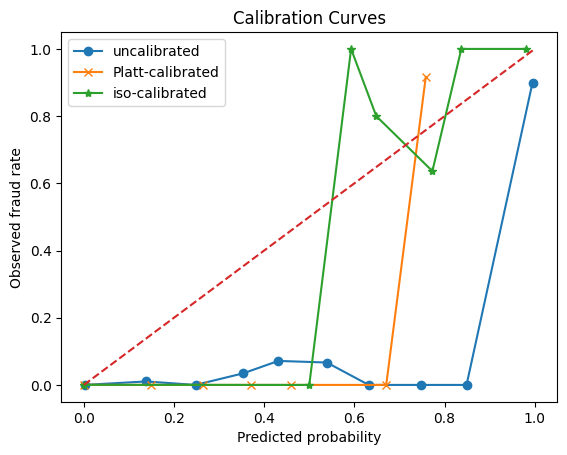

In [4]:
## Calibration curve

Y_proba_xgb = model_xgb.predict_proba(X_test)
Y_proba_platt = model_xgb_platt.predict_proba(X_test)
Y_proba_iso = model_xgb_iso.predict_proba(X_test)

prob_true, prob_pred = calibration_curve(
    Y_test,
    Y_proba_xgb[:, 1],
    n_bins=10,
    strategy='uniform'
)

prob_true_platt, prob_pred_platt = calibration_curve(
    Y_test,
    Y_proba_platt[:, 1],
    n_bins = 10,
    strategy='uniform'
)

prob_true_iso, prob_pred_iso = calibration_curve(
    Y_test,
    Y_proba_iso[:, 1],
    n_bins = 10,
    strategy='uniform'
)

plt.plot(prob_pred, prob_true, marker='o', label='uncalibrated')
plt.plot(prob_pred_platt, prob_true_platt, marker='x', label='Platt-calibrated')
plt.plot(prob_pred_iso, prob_true_iso, marker='*', label='iso-calibrated')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("Predicted probability")
plt.ylabel("Observed fraud rate")
plt.title("Calibration Curves")
plt.legend()
plt.show()


<div align="center">

**Figure - Calibration curve for the uncalibrated, Platt-scaling calibrated and Isotonic Regression calibrated models.**


Our XGBoost model doesn't respond well to calibration. We still find mostly negatives at lower thresholds and mostly positives at higher thresholds: the data is too well separated for proper calibration.

</div>

## Performance comparison: 

Let us now compare the XGBoost model to the previously described logistic regression model.   
  
Looking at the ROC and Precision-Recall curves, we can see that the XGBoost model generally outperforms the logistic regression, although there exist some recall ranges for which the logistic regression achieves a slightly higher precision. Consequently, both the ROC AUC and PR AUC of the XGBoost model are fairly higher.  
  
It would be easy to conclude that the XGBoost simply outperforms the logistic regression model, but again, those performances are too good to be true. The limited time span of the data means that the model can learn the specific fraud pattern seen over the 48-hour window, and in this context "better" might in fact mean "more overfitted".  
  
That is not to say the models didn't learn anything valuable, rather that the repeating patterns between the training and the testing sets push the models over the edge in terms of performance, and we should take said performance with a grain of salt.  
  
Since the models are doing so well on the test set and we are unable to really screen for over-fitting because of the data-set constraints, it is safe for us to assume lack of generalization will be the number one issue for our models. Since XGBoost is more susceptible to over-fitting, Logistic Regression would be the better choice despite poorer performances, given our data-set limitations.

ROC-AUC LR: 0.9380859309155978
PR-AUC LR: 0.6955300567796737
ROC-AUC XGB: 0.966354754168161
PR-AUC XGB: 0.778915692698916


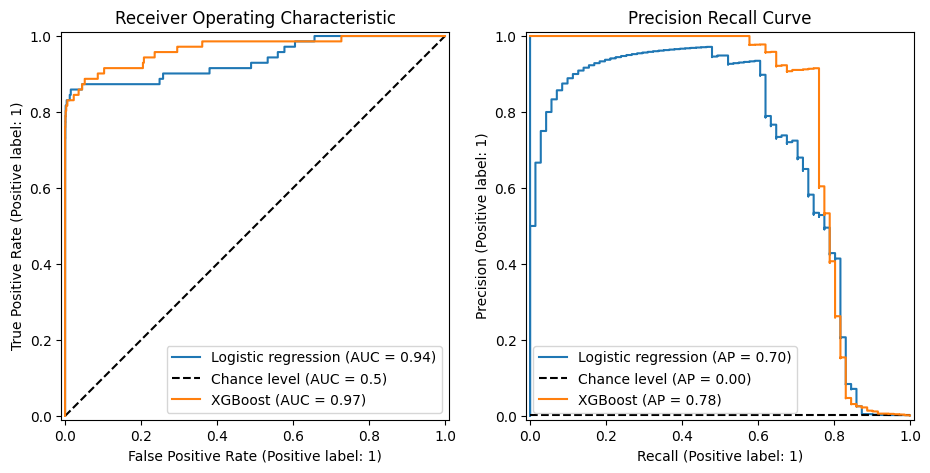

In [5]:
## Model evaluation: ROC and PR, w/wo calibration

Y_proba_xgb = model_xgb.predict_proba(X_test)
Y_proba_lr = model_lr.predict_proba(X_test)

print("ROC-AUC LR:", roc_auc_score(Y_test, Y_proba_lr[:, 1]))
print("PR-AUC LR:", average_precision_score(Y_test, Y_proba_lr[:, 1]))
print("ROC-AUC XGB:", roc_auc_score(Y_test, Y_proba_xgb[:, 1]))
print("PR-AUC XGB:", average_precision_score(Y_test, Y_proba_xgb[:, 1]))

fig, ax = plt.subplots(1, 2, figsize=(11,6))

ax[0].set_title("Receiver Operating Characteristic")
ax[1].set_title("Precision Recall Curve")

RocCurveDisplay.from_predictions(
    Y_test,
    Y_proba_lr[:, 1],
    ax=ax[0],
    name="Logistic regression",
    plot_chance_level=True
)

PrecisionRecallDisplay.from_predictions(
    Y_test,
    Y_proba_lr[:, 1],
    ax=ax[1],
    name="Logistic regression",
    plot_chance_level=True
)

RocCurveDisplay.from_predictions(
    Y_test,
    Y_proba_xgb[:, 1],
    ax=ax[0],
    name="XGBoost"
)

_ = PrecisionRecallDisplay.from_predictions(
    Y_test,
    Y_proba_xgb[:, 1],
    ax=ax[1],
    name="XGBoost"
)

<div align="center">

**Figure - Receiver Operating Characteristic and Precision Recall curve for the XGBoost and Logistic Regression models.**

The XGBoost does a bit better than the Logistic Regression, but we should keep in mind that the performances of both models are over optimistic due to dataset limitations.

</div>

## Feature importance 

One key advantage of decision trees is their strong interpretability. By computing and plotting the Shapley values, values that quantify how much each feature contributes to a given prediction, we can identify the features that are most relevant for fraud detection. This analysis can provide valuable insights into the general behavior of fraudsters, as well as more specific feedback for a client, such as why a particular transaction was flagged as suspicious.  
  
In the context of this project, the utility of this analysis is limited, as the original feature meanings are obscured by the PCA transformation. Nevertheless, we can observe that the features that exhibit the highest sum of absolute shapley values (features 14, 4, 10 and 12 for example), are all features whose distribution for fraud samples and non-fraud samples differ significatnly as identified in the first chapter. But shapley values capture more than that: a feature might be useless for prediction on its own, but useful when combined with another feature. 

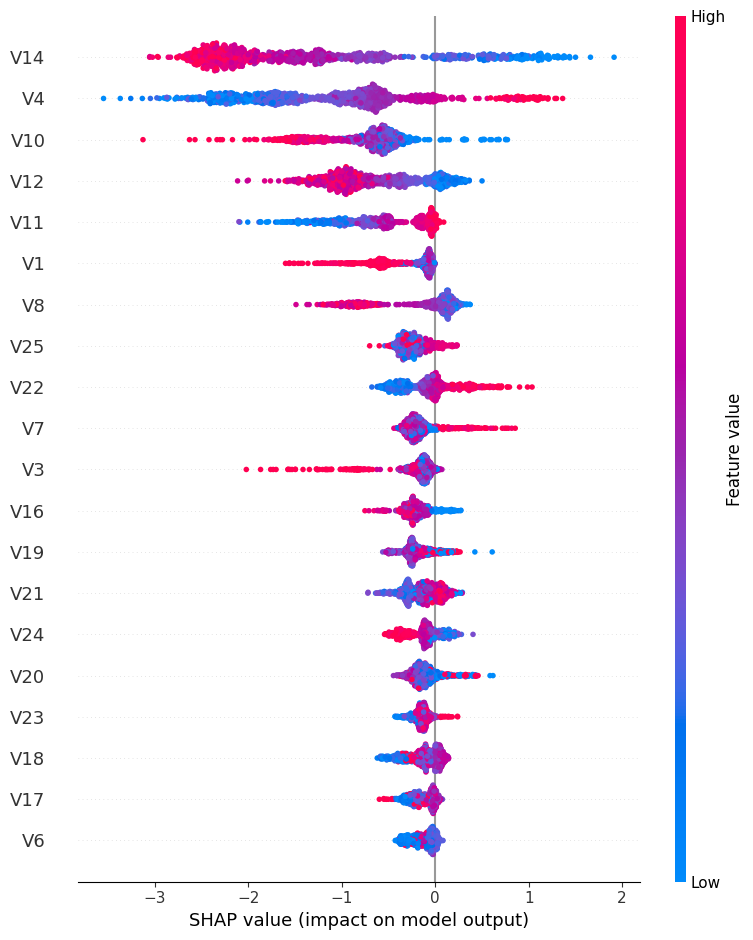

In [6]:
## Feature Importance

feature_names = [f"V{i}" for i in range(1, X_test.shape[1] + 1)]

X_sample = pd.DataFrame(
    X_test[:1000],
    columns=feature_names
)

explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_sample)
shap.summary_plot(shap_values, X_sample)

<div align="center">

**Figure - Shapey values for the XGBoost model.**

Shap values for the 28 features of the first 1000 data samples. Negative Shapley values mean that features pushed the prediction towards non-fraud for that sample, and vice-versa for positive values. Red indicates a high value for that feature, and blue a low value. If we put it all together, red data points with low Shapley values means that a higher value for that feature signals non-fraud. Features are ordered by decreasing total absolute Shapley value, which is a proxy for predictive power.
</div>

## Thresholding  
  
Thresholding using a cost function is not well suited to gradient-boosted tree models. Because the predictions are discrete and the model tends to be overconfident, many observations receive identical scores. As a result, the cost function often plateaus at its minimum over a wide range of threshold values.  
  
On the other hand, gradient-boosted trees are excellent at ranking predictions, which makes ranking-based decision rules such as recall@K or precision@K especially relevant. In a real-world setting, this would allow the decision threshold to be determined by operational constraints, for instance the amount of manpower available for review.  
  
So just out of curiosity, let us plot the recall@K and precision@K metrics (see figure below). These curves are obtained by picking the K highest scores (i.e. the K transactions that the model finds most suspicous), and, on the basis of that sample, compute the recall (what portion of the total positives is in that sample) and the precision (what portion of that sample is actually positive).  
  
As expected, recall increases with K until it reaches a plateau, while precision steadily decreases as less suspicious transactions are included.  
As with PR and ROC curves, we can take note of the slightly better early performance of the XGBoost model compared to logistic regression. This advantage disappears as K increases. 

Optimal thresholds:
relative cost =  20  :  0.9520000000000001
relative cost =  50  :  0.315
relative cost =  100  :  0.178


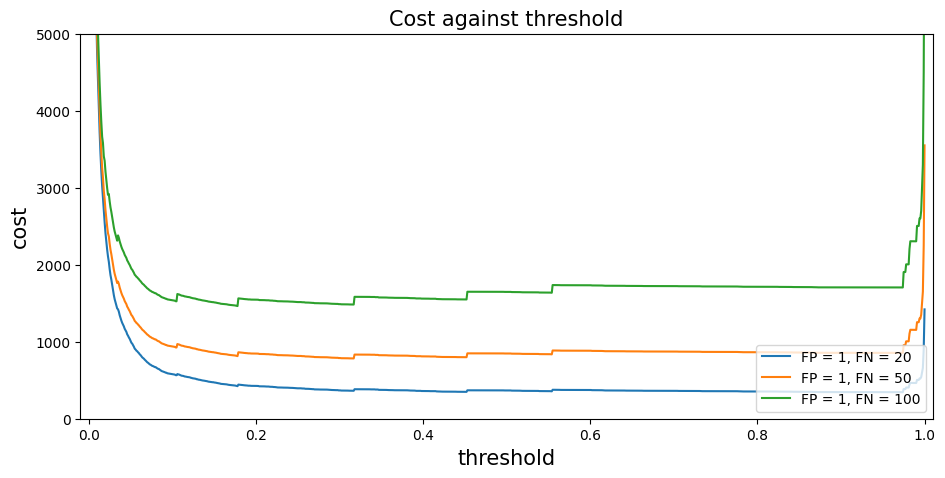

In [7]:
Y_proba_platt = model_xgb.predict_proba(X_test)

cost_function, ax = plt.subplots(1, 1, figsize=(11,5))

print("Optimal thresholds:")
for relative_cost in [20, 50, 100]:
    thresholds, costs = plot_cost_function(relative_cost, 1, Y_test.to_list(), Y_proba_platt[:, 1], ax)
    print("relative cost = ", relative_cost, " : ", thresholds[np.argmin(costs)])
    

_ = ax.set_ylim(bottom=0, top=5000)


<div align="center">

**Figure - Cost functions for the XGBoost model, for different value of the relative FN/FP costs.**

The nature of XGBoost makes costs function relatively useless: the discrete nature of the classification and over confidence makes for a very wide plateau at the minimum.

</div>

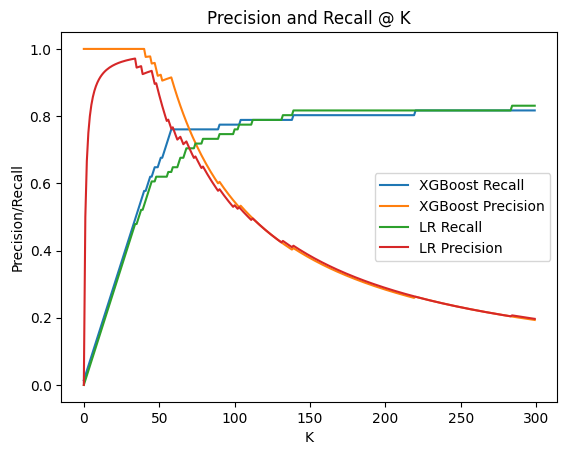

In [8]:
Y_proba_xgb = model_xgb.predict_proba(X_test)
Y_proba_lr = model_lr.predict_proba(X_test)

recalls_xgb = recalls_at_k(Y_test.to_list(), Y_proba_xgb[:, 1], 300)
precisions_xgb = precisions_at_k(Y_test.to_list(), Y_proba_xgb[:, 1], 300)

recalls_lr = recalls_at_k(Y_test.to_list(), Y_proba_lr[:, 1], 300)
precisions_lr = precisions_at_k(Y_test.to_list(), Y_proba_lr[:, 1], 300)

plt.plot(recalls_xgb, label='XGBoost Recall')
plt.plot(precisions_xgb, label='XGBoost Precision')
plt.plot(recalls_lr, label='LR Recall')
plt.plot(precisions_lr, label='LR Precision')
plt.xlabel("K")
plt.ylabel("Precision/Recall")
plt.title("Precision and Recall @ K")
_ = plt.legend()

<div align="center">

**Figure - Recall and Precision at K for K up to 300.**

Both those metrics do well at evaluating ranking-centered models such as gradient boosted trees. As for the PR and ROC curves, we can see a slight advantage of the XGBoost model over Logistic Regression

</div>

## Comparison takeaway and conclusion

Overall, this comparison highlights that different modeling choices naturally call for different evaluation strategies and decision rules. While logistic regression lends itself well to threshold-based analysis, the XGBoost model is better approached from a ranking perspective.  
  
Across these complementary viewpoints, XGBoost consistently appears to hold a slight edge over logistic regression in terms of performance. However, given the limited temporal scope of the dataset and the small number of positive cases, these results should be interpreted with caution. The observed gains may partially reflect dataset-specific patterns rather than robust improvements in generalization.  
  
Nonetheless, this exercise provides valuable insight into how model characteristics, data constraints, and evaluation choices interact in practice, and illustrates why model assessment must be adapted to both the learning algorithm and the operational context.  